<center>
<img src="pics/ConvDO.png"/>
</center>

## About

ConvDO is a Convolutional Differential Operator designed for Physics-based deep learning study.
ConvDO is PyTorch-based and only supports 2D fields at the moment.

## Installation

* Install through pip: `pip install git+https://github.com/qiauil/ConvDO`
* Install locally: Download the repository and run `./install.sh` or the following code:

```bash
python3 setup.py sdist bdist_wheel
cd dist
pip install ConvDO-*.whl
```


## A Quick How To

Here is a simple case illustrating how to use the `ConvDo` package to calculate the residual of a physical field.

[Run in colab](https://colab.research.google.com/github/qiauil/ConvDO/blob/main/README.ipynb)


### Kolmogorov flow
Kolmogorov flow is a classical turbulent flow; a snapshot of the velocity is illustrated as follows:

/home/liu/anaconda3/envs/nashmtl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


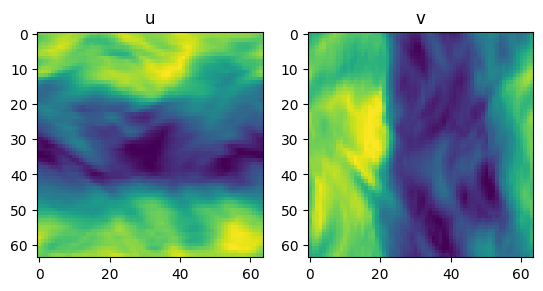

In [1]:
import torch
import matplotlib.pyplot as plt

flow= torch.load('./kf_flow.pt')
channel_names=["u","v"]

figs, axs = plt.subplots(1, 2)
for i, ax in enumerate(axs):
    ax.imshow(flow[i].numpy())
    ax.set_title(channel_names[i])
plt.show()

The flow field satisfies the divergence free condition, which is

$$
\nabla \cdot \mathbf{u}=\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}=0
$$

To calculate the divergence of the field, we can simply build a `Divergence` operator:

In [2]:
from ConvDO import *

class Divergence(FieldOperations):
    
    def __init__(self, order, device="cpu", dtype=torch.float32) -> None:
        super().__init__(order, device, dtype)
        
    def __call__(self, u:torch.Tensor,v:torch.Tensor,domain_u:Domain,domain_v:Domain):
        velocity=VectorValue(ScalarField(u,domain_u),ScalarField(v,domain_v))
        return self.nabla@velocity
        

The `order` here refers to the order of the finite difference scheme used to calculate the derivate. For periodic boundary conditions, supported orders include `2,4,6,8`. For un-periodic boundaries, only a second-order scheme is available.

The `device` and `dtype` should be inconsistent with the tensor used for the operation.

The `domain_u` and `domain_v` should be instances of the `Domain` class, which gives the boundary condition of the fields.

We use the `VectorValue` class to generate the velocity; the component of the vector is two `ScalarField` initialized with the velocity tensor and the corresponding domain. The `VectorValue` class also supports numerical numbers as its component, and we can perform some simple operations on the `VectorValue`: 

In [3]:
a=VectorValue(1,2)
b=VectorValue(3,4)
c=a+b
d=a-b
e=5*a
f=a@b
print(c,d,e,f)

(4,6) (-2,-2) (5,10) 11


`self.nabla` is the nabla operator, $\nabla$. Other supported operator includes the Laplacian operator `self.nabla2` = $\nabla^2$ and gradient operators `self.grad_x` = $\partial/\partial x$ and `self.grad_y` = $\partial/\partial y$. For instance, the `Divergence` operator can also be written as

In [4]:
class Divergence_new(FieldOperations):
    
    def __init__(self, order, device="cpu", dtype=torch.float32) -> None:
        super().__init__(order, device, dtype)
        
    def __call__(self, u:torch.Tensor,v:torch.Tensor,domain_u:Domain,domain_v:Domain):
        return self.grad_x*ScalarField(u,domain_u)+self.grad_y*ScalarField(v,domain_v)

If you want to use these operators out of the `FieldOperations` class, you can also simply create them as follows:

In [5]:
nabla = HONabla(order=2)
nabla2 = HOLaplacian(order=2)
grad_x = HOGrad(order=2,direction="x")
grad_y = HOGrad(order=2,direction="y")

Then, we can set up the computational domain of the field and calculate the divergence. The boundary condition of Kolmogorov flow is periodic thus we will set up a periodic domain. Here, `delta_x` and `delta_y` is the physical distance between mesh cells in the field. Besides `PeriodicDomain`, you can directly use the `Domain` class to add different boundary conditions and even obstacles inside the field. 

Now, let's calculate the divergence!

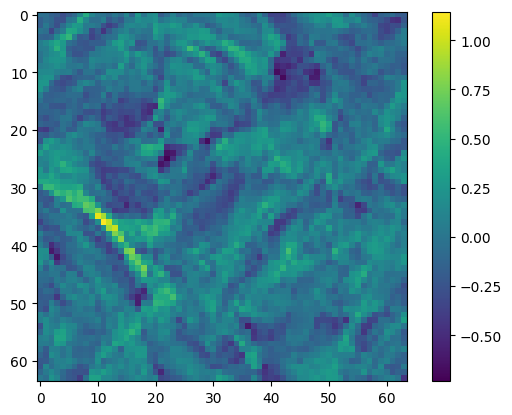

In [6]:
u=flow[0]
v=flow[1]
divergence=Divergence(order=6)
domain=PeriodicDomain(delta_x=2*3.14/64,delta_y=2*3.14/64)
residual=divergence(u,v,domain,domain).value.numpy().squeeze().squeeze()
plt.imshow(residual)
plt.colorbar()
plt.show()

Since the operation is based on the convolution provided by PyTorch, it supports batched input and output. If your input of a `ScalarField` only contains 2 dimensions $H \times W$, it will automatically convert to a new tensor with the shape of $B\times C \times H \times W$. The shape of the output is always $B\times C \times H \times W$.

Also, thanks to PyTorch, all the operation is differentiable. For example, we can directly use gradient descent method to make the flow field more divergence free.

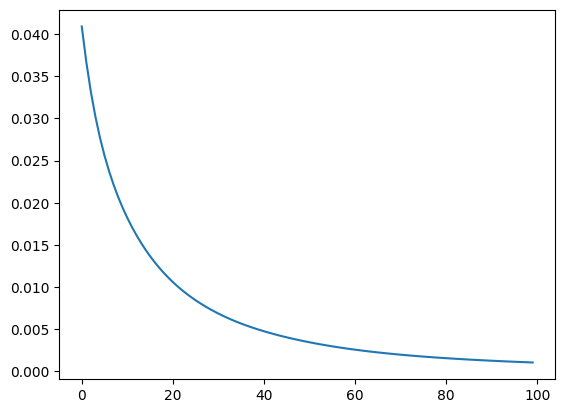

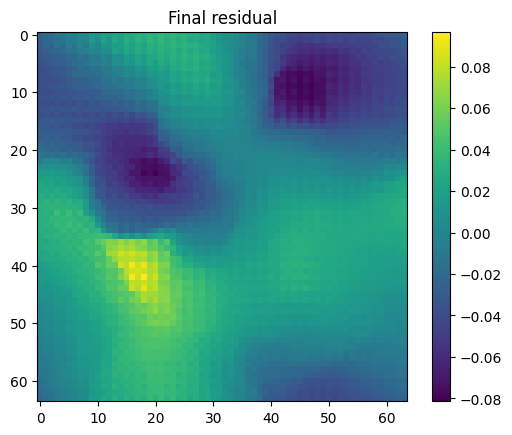

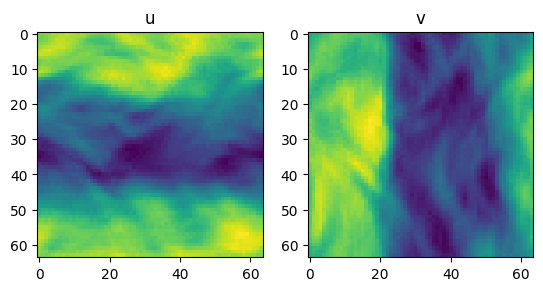

In [7]:
losses=[]
optimizer = torch.optim.Adam([u,v],lr=0.001)
u.requires_grad=True
v.requires_grad=True
for i in range(100):
    optimizer.zero_grad()
    residual=divergence(u,v,domain,domain).value
    loss=torch.mean(residual**2)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
plt.plot(losses)
plt.show()
plt.imshow(residual.detach().numpy().squeeze().squeeze())
plt.colorbar()
plt.title("Final residual")
plt.show()
fig, axs = plt.subplots(1, 2)
for i, ax in enumerate(axs):
    ax.imshow(flow[i].detach().numpy())
    ax.set_title(channel_names[i])
plt.show()

We could also use this feature to solve some PDEs with gradient descent. For example, we could solve the [2D lid-driven cavity flow](https://www.researchgate.net/publication/324413434_The_Lid-Driven_Cavity):

Loss: 38669.840: 100%|██████████| 50000/50000 [05:34<00:00, 149.49it/s]


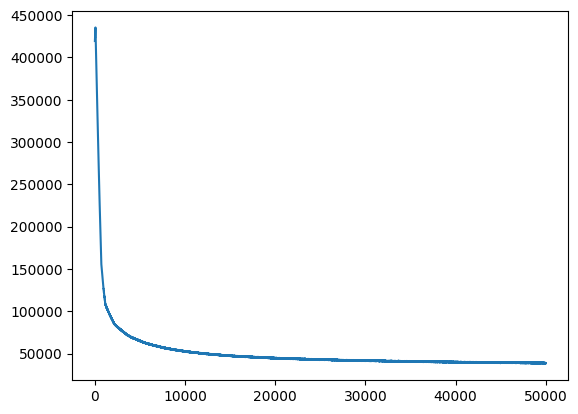

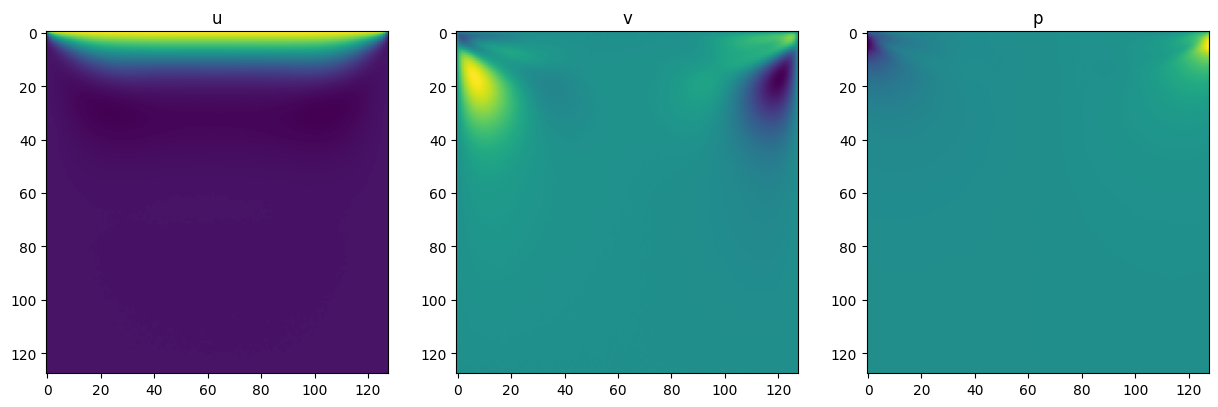

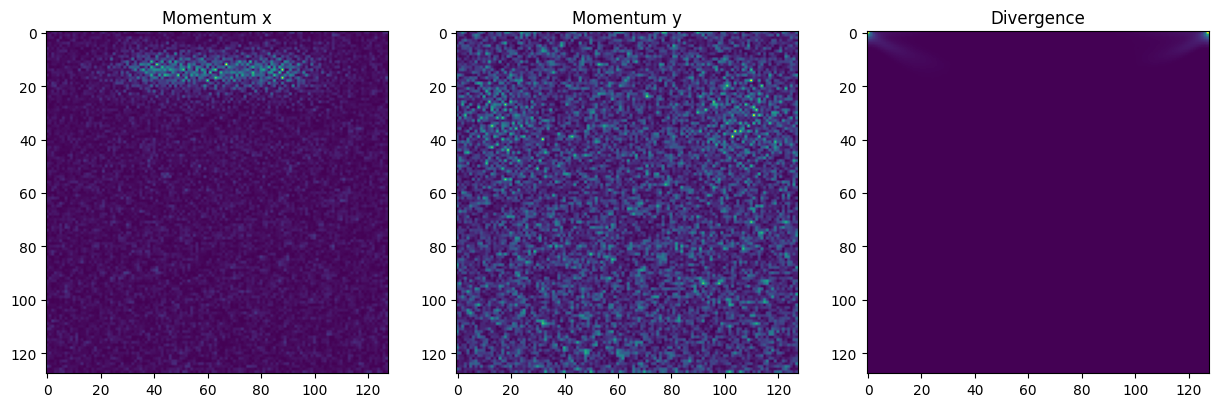

In [8]:
from tqdm import tqdm

class SteadyNS(FieldOperations):
    
    def __init__(self, Re,order=2, device="cpu", dtype=torch.float32) -> None:
        super().__init__(order, device, dtype)
        self.Re=Re
        
    def __call__(self, 
                 u:torch.Tensor,
                 v:torch.Tensor,
                 p:torch.Tensor,
                 domain_u:Domain,
                 domain_v:Domain,
                 domain_p:Domain):
        u=ScalarField(u,domain_u)
        v=ScalarField(v,domain_v)
        p=ScalarField(p,domain_p)
        velocity=VectorValue(u,v)
        viscosity=self.nabla2*velocity*(1/self.Re)
        momentum_x=self.grad_x*u*u+self.grad_y*u*v+self.grad_x*p-viscosity.ux
        momentum_y=self.grad_x*v*u+self.grad_y*v*v+self.grad_y*p-viscosity.uy
        divergence=self.nabla@velocity
        return momentum_x.value.abs(),momentum_y.value.abs(),divergence.value.abs()

operator=SteadyNS(Re=10,order=2)

N=128

domain_u=Domain(
    boundaries=[
        DirichletBoundary(0.0),
        DirichletBoundary(0.0),
        DirichletBoundary(1.0),
        DirichletBoundary(0.0)],
    delta_x=1.0/N,
    delta_y=1.0/N,)

domain_v=Domain(boundaries=[DirichletBoundary(0.0)]*4,
                delta_x=1.0/N,
                delta_y=1.0/N,)

domain_p=Domain(boundaries=[NeumannBoundary(0.0)]*4,               
                delta_x=1.0/N,
                delta_y=1.0/N,)
        
uvp=torch.zeros((3,N,N),requires_grad=True)
optimizer = torch.optim.Adam([uvp],lr=0.001)
losses=[]
p_bar=tqdm(range(50000))
for i in p_bar:
    optimizer.zero_grad()
    m_x,m_y,c=operator(uvp[0],uvp[1],uvp[2],domain_u,domain_v,domain_p)
    loss=m_x.sum()+m_y.sum()+c.sum()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    p_bar.set_description("Loss: {:.3f}".format(loss.item()))
plt.plot(losses)

channel_names=["u","v","p"]
fig,ax=plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    ax[i].imshow(uvp[i].detach().numpy())
    ax[i].set_title(channel_names[i])
plt.show()

channel_names=["Momentum x","Momentum y","Divergence"]
residuals=operator(uvp[0],uvp[1],uvp[2],domain_u,domain_v,domain_p)
fig,ax=plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    ax[i].imshow(residuals[i].detach().numpy().squeeze().squeeze())
    ax[i].set_title(channel_names[i])

plt.show()

## Further Reading

Projects using `ConvDO`:
* [Diffusion-based-Flow-Prediction](https://github.com/tum-pbs/Diffusion-based-Flow-Prediction): Diffusion-based flow prediction (DBFP) with uncertainty for airfoils.
* To be updated... 

If you need to solve more complex PDEs using differentiable functions, please have a check on [PhiFlow](https://github.com/tum-pbs/PhiFlow) project.

For more research on physics based deep learning research, please visit the website of our research group at TUM: https://ge.in.tum.de/publications/.